In [45]:
# Data Handling
import pandas as pd
import numpy as np
import os
import re
import string
# NLP Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Data Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Preprocessing Utilities
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
# Machine Learning Utilities
from sklearn.model_selection import train_test_split
# Download necessary NLP resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EZZRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EZZRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EZZRA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\EZZRA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [46]:
file_paths = glob.glob("data/*.csv")  

df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

print(f"Total data setelah digabungkan: {df.shape[0]} baris dan {df.shape[1]} kolom")


Total data setelah digabungkan: 164972 baris dan 8 kolom


## Exploratory Data Analysis (EDA)

In [47]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Isi missing values dengan 'Unknown'
df.fillna("Unknown", inplace=True)


Missing Values:
 sender           115443
receiver         117204
date             115595
subject           82833
body              82487
label                 0
urls             115112
text_combined     82486
dtype: int64


C:\Users\EZZRA\AppData\Local\Temp\ipykernel_9192\859388186.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Unknown", inplace=True)


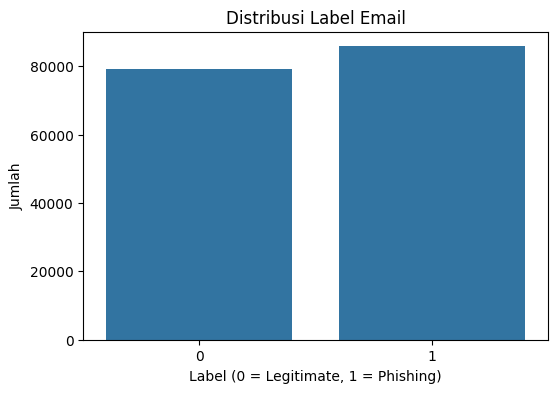

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.title("Distribusi Label Email")
plt.xlabel("Label (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Jumlah")
plt.show()


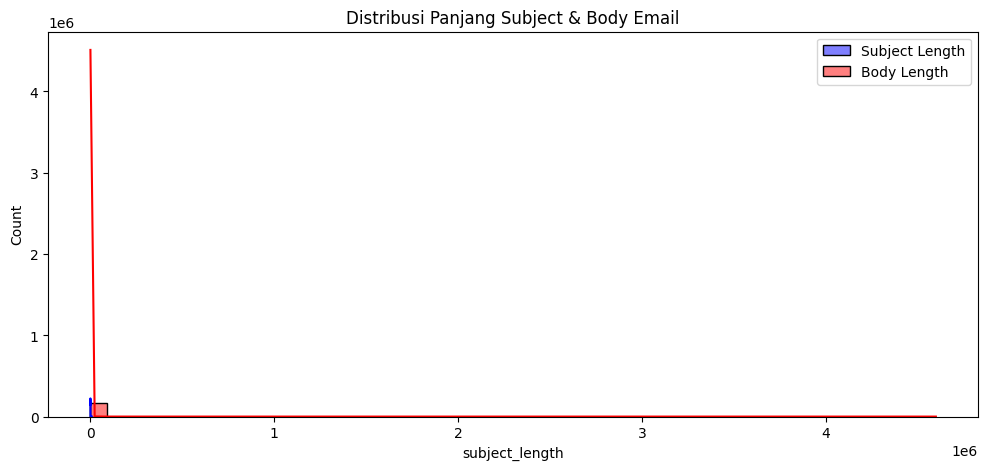

In [49]:
df['subject_length'] = df['subject'].apply(lambda x: len(str(x)))
df['body_length'] = df['body'].apply(lambda x: len(str(x)))

plt.figure(figsize=(12,5))
sns.histplot(df['subject_length'], bins=50, kde=True, color='blue', label='Subject Length')
sns.histplot(df['body_length'], bins=50, kde=True, color='red', label='Body Length')
plt.legend()
plt.title("Distribusi Panjang Subject & Body Email")
plt.show()


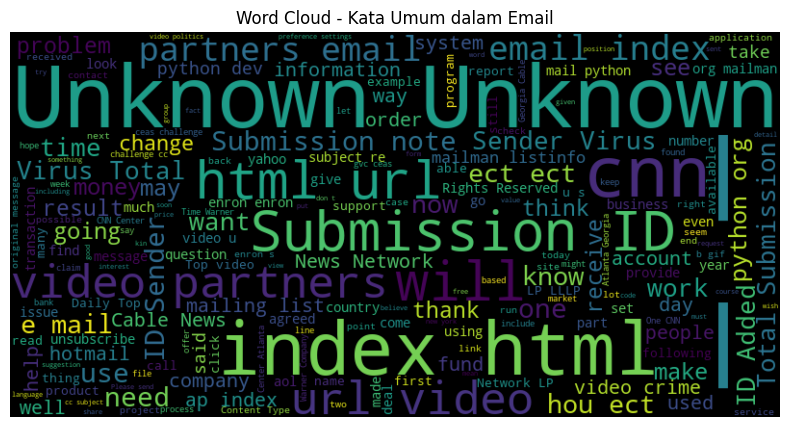

In [50]:
text_corpus = ' '.join(df['body'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_corpus)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Kata Umum dalam Email")
plt.show()


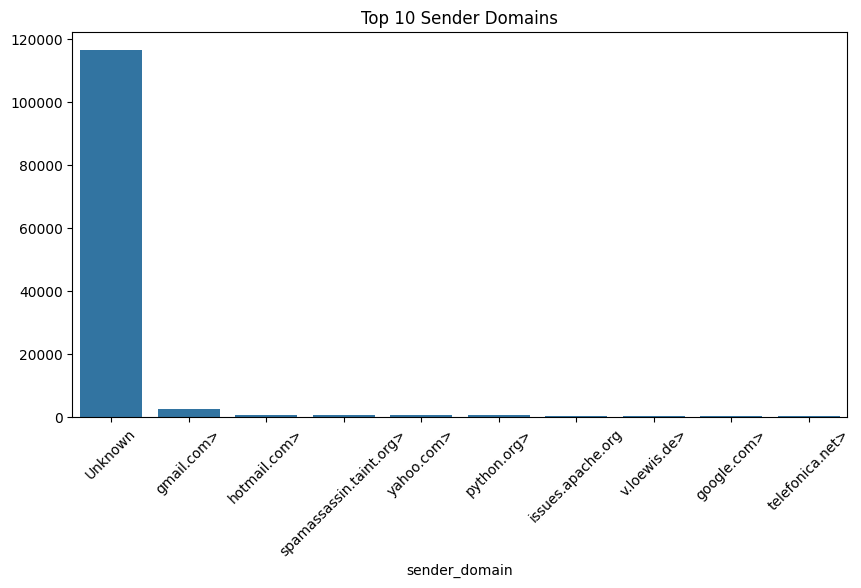

In [51]:
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1] if '@' in str(x) else 'Unknown')

top_domains = df['sender_domain'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_domains.index, y=top_domains.values)
plt.xticks(rotation=45)
plt.title("Top 10 Sender Domains")
plt.show()


## Data Preprocessing

In [52]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<[^>]*>', '', text)  # Hapus HTML tags
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Stopword removal
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)

df['subject'] = df['subject'].apply(clean_text)
df['body'] = df['body'].apply(clean_text)


In [53]:
def extract_domain(url):
    try:
        return urlparse(url).netloc
    except:
        return 'Unknown'

df['url_domain'] = df['urls'].apply(extract_domain)


In [54]:
sia = SentimentIntensityAnalyzer()

def sentiment_score(text):
    score = sia.polarity_scores(text)
    return score['compound']

df['subject_sentiment'] = df['subject'].apply(sentiment_score)
df['body_sentiment'] = df['body'].apply(sentiment_score)


In [55]:
df['capital_letters'] = df['body'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['num_digits'] = df['body'].apply(lambda x: sum(1 for c in x if c.isdigit()))
df['num_special_chars'] = df['body'].apply(lambda x: sum(1 for c in x if c in string.punctuation))


## FEATURE EXTRACTION (TF-IDF, BoW, Word Embeddings)

In [56]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['subject'] + ' ' + df['body'])

# BoW Vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_bow = count_vectorizer.fit_transform(df['subject'] + ' ' + df['body'])


## FINAL: PREPARASI DATA UNTUK MODEL

In [59]:
df

,sender,receiver,date,subject,body,label,urls,text_combined,subject_length,body_length,sender_domain,url_domain,subject_sentiment,body_sentiment,capital_letters,num_digits,num_special_chars
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",never agree loser,buck trouble caused small dimension soon becom...,1,1.0,Unknown,25,273,iworld.de>,Unknown,0.1695,0.2732,0,0,0
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",befriend jenna jameson,upgrade sex pleasure technique httpwwwbrightma...,1,1.0,Unknown,22,82,icable.ph>,Unknown,0.0000,0.5719,0,0,0
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",cnncom daily top,daily top cnncom top video story aug pm edt to...,1,1.0,Unknown,20,3918,universalnet.psi.br>,Unknown,0.2023,-0.9933,0,0,0
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",svn commit r spamassassintrunk libmailspamassa...,would anyone object removing list tld basicall...,0,1.0,Unknown,150,24418,pobox.com>,Unknown,0.2960,0.9858,0,0,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",specialpricespharmmoreinfo,welcomefastshippingcustomersupport httpiwfnabl...,1,1.0,Unknown,26,175,loanofficertool.com>,Unknown,0.0000,0.0000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164967,Professional_Career_Development_Institute@Frug...,yyyy@netnoteinc.com,"Tue, 3 Dec 2002 13:19:58 -0800",busy home study make sense,httpimagespcdihomestudycomadseunisexheadergif ...,1,1.0,Unknown,29,3177,FrugalJoe.com,Unknown,0.0000,0.9916,0,0,0
164968,"""IQ - TBA"" <tba@insiq.us>",<yyyy@spamassassin.taint.org>,"Tue, 3 Dec 2002 18:52:29 -0500",preferred nonsmoker rate smoker,multipart message mime format nextpartbddbcaec...,1,1.0,Unknown,38,3853,insiq.us>,Unknown,0.0000,0.9865,0,0,0
164969,Mike <raye@yahoo.lv>,Mailing.List@user2.pro-ns.net,"Sun, 20 Jul 2003 16:19:44 +0800",get free hit per day website,dear subscriber could show way get visitor day...,1,1.0,Unknown,50,2470,yahoo.lv>,Unknown,0.5106,0.9921,0,0,0
164970,"""Mr. Clean"" <cweqx@dialix.oz.au>",<Undisclosed.Recipients@webnote.net>,"Wed, 05 Aug 2020 04:01:50 -1900",cannabis difference,midsummer customer appreciation sale express a...,1,0.0,Unknown,19,23773,dialix.oz.au>,b'',0.0000,0.9999,0,0,0


In [57]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

print("Shape Training Data:", X_train.shape)
print("Shape Testing Data:", X_test.shape)


Shape Training Data: (131977, 5000)
Shape Testing Data: (32995, 5000)


In [60]:
df.drop(columns=['receiver', 'date'], inplace=True)


In [61]:
df

,sender,subject,body,label,urls,text_combined,subject_length,body_length,sender_domain,url_domain,subject_sentiment,body_sentiment,capital_letters,num_digits,num_special_chars
0,Young Esposito <Young@iworld.de>,never agree loser,buck trouble caused small dimension soon becom...,1,1.0,Unknown,25,273,iworld.de>,Unknown,0.1695,0.2732,0,0,0
1,Mok <ipline's1983@icable.ph>,befriend jenna jameson,upgrade sex pleasure technique httpwwwbrightma...,1,1.0,Unknown,22,82,icable.ph>,Unknown,0.0000,0.5719,0,0,0
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,cnncom daily top,daily top cnncom top video story aug pm edt to...,1,1.0,Unknown,20,3918,universalnet.psi.br>,Unknown,0.2023,-0.9933,0,0,0
3,Michael Parker <ivqrnai@pobox.com>,svn commit r spamassassintrunk libmailspamassa...,would anyone object removing list tld basicall...,0,1.0,Unknown,150,24418,pobox.com>,Unknown,0.2960,0.9858,0,0,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,specialpricespharmmoreinfo,welcomefastshippingcustomersupport httpiwfnabl...,1,1.0,Unknown,26,175,loanofficertool.com>,Unknown,0.0000,0.0000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164967,Professional_Career_Development_Institute@Frug...,busy home study make sense,httpimagespcdihomestudycomadseunisexheadergif ...,1,1.0,Unknown,29,3177,FrugalJoe.com,Unknown,0.0000,0.9916,0,0,0
164968,"""IQ - TBA"" <tba@insiq.us>",preferred nonsmoker rate smoker,multipart message mime format nextpartbddbcaec...,1,1.0,Unknown,38,3853,insiq.us>,Unknown,0.0000,0.9865,0,0,0
164969,Mike <raye@yahoo.lv>,get free hit per day website,dear subscriber could show way get visitor day...,1,1.0,Unknown,50,2470,yahoo.lv>,Unknown,0.5106,0.9921,0,0,0
164970,"""Mr. Clean"" <cweqx@dialix.oz.au>",cannabis difference,midsummer customer appreciation sale express a...,1,0.0,Unknown,19,23773,dialix.oz.au>,b'',0.0000,0.9999,0,0,0
